In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
plt.style.use('seaborn')

import investpy

In [684]:
class Portfolio:

    def __init__(self, riskFreeRate, expecReturn, covMatrix, VarStdConv = True, names = []):
        
        self.riskFreeRate = riskFreeRate
        self.expecReturn = np.matrix(expecReturn).T
        self.covMatrix = np.matrix(covMatrix)
        self.ones = np.matrix(np.ones(len(expecReturn))).T
        self.abcd()
        self.variance = VarStdConv
        self.assetNames = names

    

    def abcd(self):

        a = np.matmul(self.expecReturn.T,np.matmul(np.linalg.inv(self.covMatrix),self.ones))
        b = np.matmul(self.expecReturn.T,np.matmul(np.linalg.inv(self.covMatrix),self.expecReturn))
        c = np.matmul(self.ones.T,np.matmul(np.linalg.inv(self.covMatrix),self.ones))
        d = b*c - a*a

        self.v_abcd = a,b,c,d


    def efficFront(self,mu):

        a,b,c,d = self.v_abcd

        sigma2 = (c/d)*mu*mu - ((2*a)/d)*mu + (b/d)

        return sigma2[0,0]

    def efficientFrontier(self, variance = True, vMu = np.arange(0,0.5,0.01)):
        """Compute the Efficient Frontier

        Parameters
        ----------
        variance: bool, optional
            Indicate if the x-axis is Variance or Standard Deviation (default is True)
        
        vMu: array, optional
            Array of returns, y-axis (default is from 0 to 0.5)

        Returns
        ----------
        dict
            A list of lists [Variance or Std, Expected Return]

        """
        if self.variance:

            self.frontier = [list(map(self.efficFront,vMu)),vMu]

        else:
            temp = [list(map(self.efficFront,vMu)),vMu]
            temp[0] = np.sqrt(temp[0])
            self.frontier = temp

        return self.frontier

    def minVar(self, variance = True):
        """Compute the Minimun Variance Portfolio

        Parameters
        ----------
        none

        Returns
        ----------
        float
            Expected Return

        float
            Variance or Standard Deviation

        list
            Portfolio Weights
        """
        a,b,c,d = self.v_abcd

        mu = a/c
        
        if self.variance:
            s = 1/c
        else:
            s = 1/(np.sqrt(c))

        w = (np.matmul(np.linalg.inv(self.covMatrix),self.ones))/c
        w = w.tolist()
        w = [val for sublist in w for val in sublist]

        self.minVarPort = [s[0,0], mu[0,0], w]

        return self.minVarPort

    def tangent(self):
        """Compute the Tangent Portfolio

        Parameters
        ----------
        none

        Returns
        ----------
        float
            Expected Return

        float
            Variance or Standard Deviation

        list
            Portfolio Weights
        """

        if hasattr(self,'tanPort'):
            return self.tanPort
        
        else:

            a,b,c,d = self.v_abcd

            mu = (a*self.riskFreeRate-b)/(c*self.riskFreeRate - a)
            
            if self.variance:
                s = self.efficFront(mu)
            else:
                s = np.sqrt(self.efficFront(mu))

            w = (np.matmul(np.linalg.inv(self.covMatrix),self.ones*self.riskFreeRate)) / \
                    np.matmul(self.ones.T,(np.matmul(np.linalg.inv(self.covMatrix),self.ones*self.riskFreeRate)))

            w = w.tolist()
            w = [val for sublist in w for val in sublist]

            self.tanPort = [s, mu[0,0], w]

            return self.tanPort

    def optimal(self, riskAver): 
        """Compute the Optimal Portfolio

        Parameters
        ----------
        float
            Risk Aversion

        Returns
        ----------
        float
            Expected Return

        float
            Variance or Standard Deviation

        list
            Portfolio Weights
        """

        if not hasattr(self,'tanPort'):
            self.tangent()

        if self.variance:
            sp = (self.tanPort[1] - self.riskFreeRate)/np.sqrt(self.tanPort[0])
            s = ((1/riskAver)*sp)**2
            y = (1/riskAver)*(sp/np.sqrt(self.tanPort[0]))
            mu = self.riskFreeRate + (1/riskAver)*(sp*sp)

        else:
            sp = (self.tanPort[1] - self.riskFreeRate)/self.tanPort[0]
            s = (1/riskAver)*sp
            y = (1/riskAver)*(sp/self.tanPort[0])
            mu = self.riskFreeRate + (1/riskAver)*(sp*sp)

        w = [i * y for i in self.tanPort[2]]
        w.append(1-y)

        self.optPort = [s, mu, w]

        return self.optPort

    def kelly(self):
        """Compute the Kelly Criterion Portfolio

        Parameters
        ----------
        none

        Returns
        ----------
        float
            Expected Return

        float
            Variance or Standard Deviation

        list
            Portfolio Weights
        """

        w = (1+self.riskFreeRate)*np.matmul(np.linalg.inv(self.covMatrix),(self.expecReturn-self.riskFreeRate))
        
        
        mu = np.matmul(w.T,self.expecReturn) + (self.riskFreeRate*(1-(sum(w))))
        
        s = np.matmul(w.T,np.matmul(self.covMatrix,w))


        if not self.variance:
            s = np.sqrt(s)
        

        w = w.tolist()
        w = [val for sublist in w for val in sublist]

        w.append(1-(sum(w)))

        self.kellyPort= [s[0,0], mu[0,0], w]

        return self.kellyPort

    def CAL(self, mult = 2):

        if not hasattr(self,'tanPort'):
            self.tangent()

        if self.variance:
            sp = (self.tanPort[1] - self.riskFreeRate)/np.sqrt(self.tanPort[0])

        else:
            sp = (self.tanPort[1] - self.riskFreeRate)/self.tanPort[0]

        rr = np.arange(0,self.tanPort[1]*mult,0.01)

        self.cal = rr, [sp*i+self.riskFreeRate for i in rr]

        return self.cal

    def util(self, riskAv, mult = 2):

        if not hasattr(self,'optPort'):
            self.optimal()

        if not self.variance:
            s = self.optPort[0]**2
            u = self.optPort[1] - 0.5 * riskAv * s
            rng = np.arange(u,u+mult*riskAv*s,0.01)
            self.utilCurve = [np.sqrt((2/riskAv)*(r - u)) for r in rng], rng

        else:
            s = self.optPort[0]
            u = self.optPort[1] - 0.5 * riskAv * s
            rng = np.arange(u,u+mult*riskAv*s,0.01)
            rng = np.arange(u,0.5,0.01)
            self.utilCurve = [((2/riskAv)*(r - u)) for r in rng], rng


        

        return self.utilCurve


class RiskMetrics:

    def __init__(self, ret, risk, notional = 1, variance = True):
        self.ret = ret
        self.variance = variance
        self.notional = notional
        if variance:
            self.risk = np.sqrt(risk)
        else:
            self.risk = risk

    def valueAtRisk(self, alpha, period=1):

        years = period/252
        self.var = (norm.ppf(alpha)*self.risk*np.sqrt(years) + self.ret*years) * self.notional

        return self.var

    def cValueAtRisk(self, alpha, period=1):

        years = period/252
        self.cvar = (self.ret*years - ((self.risk*np.sqrt(years))/alpha)* norm.pdf(norm.ppf(alpha)))\
            * self.notional

        return self.cvar

class Market:

    def __init__(self,assets, period, country='brazil'):
        self.assets = assets
        self.period = period
        self.country = country
    
    def getPrices(self):

        if hasattr(self,'prices'):
            return self.prices

        else:

            dfPrice = pd.DataFrame()
            dfMCap = []

            for asset in self.assets:
                try:
                    p = pd.Series(investpy.get_stock_historical_data(stock=asset,
                            country=self.country,
                            from_date= self.period[0],
                            to_date= self.period[1])['Close'],name=asset)
                
                    dfPrice = pd.concat([dfPrice,p], axis = 1)

                    c = investpy.get_stock_information(stock=asset,
                            country=self.country)['Market Cap']
                    
                    dfMCap.append(c.values[0])
                except:
                    pass
                    
            dfPrice.dropna(how='any', inplace=True)
            

            self.prices = dfPrice
            self.mktCap = dfMCap

    def getReturns(self):

        if not hasattr(self,'prices'):
            self.getPrices()

        if not hasattr(self,'returns'):
            self.returns = dfReturns = self.prices.pct_change(1)[1:]            


    def getMetrics(self):

        self.vMean = self.returns.mean() * 252
        self.mCov = self.returns.cov() * 252


class BlackLitterman:

    def __init__(self,riskAv, covMatrix, mktCap, riskFree, shrink, mktViews, retViews, errorViews):
        self.riskAv = riskAv
        self.cov = np.matrix(covMatrix)
        self.mktCap = mktCap
        self.w = mktCap/sum(mktCap)
        self.r = riskFree
        self.t = shrink
        self.P = np.matrix(mktViews)
        self.Q = np.matrix(retViews).T
        self.omega = np.matrix(errorViews)

    def getReturns(self):

        self.returns = np.matrix((self.riskAv * np.matmul(self.cov, self.w) + self.r)).T

    def posterior(self):

        ret = np.matmul(np.linalg.inv(np.linalg.inv(self.t*self.cov) + \
            np.matmul(self.P.T, np.matmul(np.linalg.inv(self.omega),self.P))),\
            np.matmul(np.linalg.inv(self.t*self.cov),self.returns) + \
            np.matmul(self.P.T, np.matmul(np.linalg.inv(self.omega),self.Q)))
        
        cov = np.linalg.inv(np.linalg.inv(self.t*self.cov) + \
            np.matmul(self.P.T, np.matmul(np.linalg.inv(self.omega),self.P)))
        
        self.postReturn = self.returns = [item for sublist in ret.tolist() for item in sublist]

        self.postCov = cov + self.cov
    

        


In [685]:
r = 0.05
exp = [0.08,0.13, 0.18, 0.25, 0.30]
cov = [[0.12, 0.06, -0.01, 0.03, 0.05],[0.06, 0.2, -0.01, 0.02, 0.04],[-0.01,-0.01, 0.3, 0.05, -0.01],
        [0.03,0.02,0.05,0.40,0.06],[0.05,0.04,-0.01,0.06,0.5]]
riskAv = 2.85
P1 = Portfolio(r, exp, cov, VarStdConv = False, names=['Asset 1','Asset 2','Asset 3','Asset 4','Asset 5','Risk Free'])


In [686]:
a = P1.efficientFrontier(variance = False)
b = P1.minVar()
c = P1.tangent()
d = P1.optimal(riskAv)
cal = P1.CAL(mult = 3)
k = P1.kelly()
u = P1.util(riskAv, mult=3)

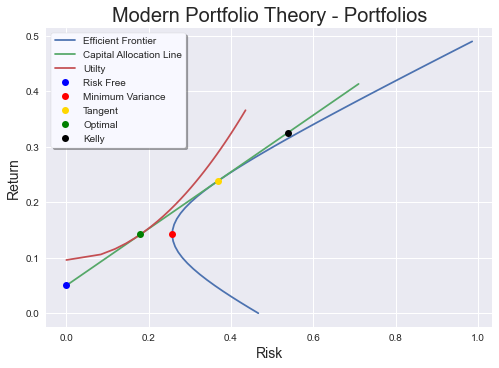

In [687]:
fig, ax = plt.subplots()

ax.plot(a[0],a[1], label="Efficient Frontier")
ax.plot(cal[0],cal[1], label="Capital Allocation Line") # CAL
ax.plot(u[0],u[1], label="Utilty") # Util
ax.plot(0,r, 'o', color='b', label="Risk Free") # rf
ax.plot(b[0],b[1], 'o', color='r', label="Minimum Variance") # minVar
ax.plot(c[0],c[1], 'o', color='gold', label="Tangent") # tangent
ax.plot(d[0],d[1], 'o', color='g', label="Optimal") # optimal
ax.plot(k[0],k[1], 'o', color='black', label="Kelly") # optimal


ax.legend(frameon=True, shadow=True, facecolor="ghostwhite")
ax.set_title("Modern Portfolio Theory - Portfolios", size=20)
ax.set_xlabel("Risk", size=14)
ax.set_ylabel("Return", size=14)
leg = ax.get_legend_handles_labels()
plt.show()
fig.savefig('MPT1.png')

In [730]:
table0 = pd.DataFrame([b[2],c[2],d[2],k[2]],index=leg[-1][4:],
            columns=P1.assetNames)\
                .fillna(0)

print(table0.to_latex(longtable=False, float_format="{:0.2%}".format))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Asset 1 &  Asset 2 &  Asset 3 &  Asset 4 &  Asset 5 &  Risk Free \\
\midrule
Minimum Variance &   42.41\% &   19.28\% &   22.92\% &    8.50\% &    6.89\% &      0.00\% \\
Tangent          &   42.41\% &   19.28\% &   22.92\% &    8.50\% &    6.89\% &      0.00\% \\
Optimal          &   20.73\% &    9.42\% &   11.20\% &    4.15\% &    3.37\% &     51.13\% \\
Kelly            &  -18.06\% &   36.00\% &   41.05\% &   39.80\% &   47.47\% &    -46.26\% \\
\bottomrule
\end{tabular}



In [333]:
risk = RiskMetrics(d[1],d[0], notional = 100000)
var = risk.valueAtRisk(0.05,1)
cvar = risk.cValueAtRisk(0.05,1)
print('VaR: $ {:,.2f}'.format(var))
print('CVaR: $ {:,.2f}'.format(cvar))

VaR: $ -4,334.54
CVaR: $ -5,450.00


In [334]:
d

[0.17957436586779668,
 0.14190381569894073,
 [0.2072983077320377,
  0.09421322271067778,
  0.11204192854593897,
  0.04153030048883762,
  0.033664971068424594,
  0.5112512694540834]]

In [414]:
assets = ['ITUB4', 'PETR4', 'B3SA3', 'RENT3', 'WEGE3', 'TAEE11', \
        'VALE3', 'BPAC11', 'LCAM3', 'EQTL3']

period = ['20/07/2017','20/07/2022']

M1 = Market(assets,period)

In [416]:
M1.mktCap

[214440000000.0,
 466370000000.0,
 66620000000.00001,
 56160000000.0,
 117660000000.0,
 13940000000.0,
 320240000000.0,
 118090000000.0,
 12250000000.0,
 27290000000.0]

In [415]:
M1.getPrices()

In [417]:
M1.getReturns()

In [418]:
M1.getMetrics()

In [722]:
print(M1.vMean.T.to_latex(longtable=False, float_format="{:0.2%}".format))

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
ITUB4  & 12.20\% \\
PETR4  & 29.03\% \\
B3SA3  & 20.71\% \\
RENT3  & 35.45\% \\
WEGE3  & 34.64\% \\
TAEE11 & 17.39\% \\
VALE3  & 33.93\% \\
BPAC11 & 51.41\% \\
LCAM3  & 40.96\% \\
EQTL3  & 19.87\% \\
\bottomrule
\end{tabular}



In [720]:
print(M1.mCov.to_latex(longtable=False, float_format="{:0.2%}".format))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  ITUB4 &  PETR4 &  B3SA3 &  RENT3 &  WEGE3 &  TAEE11 &  VALE3 &  BPAC11 &  LCAM3 &  EQTL3 \\
\midrule
ITUB4  & 10.67\% &  9.06\% &  7.35\% &  7.54\% &  4.33\% &   2.94\% &  4.76\% &   8.36\% &  6.35\% &  4.70\% \\
PETR4  &  9.06\% & 23.45\% &  9.39\% & 10.36\% &  6.55\% &   3.59\% &  8.73\% &  11.28\% & 10.26\% &  5.73\% \\
B3SA3  &  7.35\% &  9.39\% & 15.89\% & 10.41\% &  7.24\% &   3.76\% &  5.28\% &  11.95\% &  9.17\% &  6.31\% \\
RENT3  &  7.54\% & 10.36\% & 10.41\% & 21.68\% &  7.53\% &   3.95\% &  5.65\% &  12.41\% & 16.78\% &  6.69\% \\
WEGE3  &  4.33\% &  6.55\% &  7.24\% &  7.53\% & 14.53\% &   2.65\% &  4.02\% &   7.16\% &  7.54\% &  4.37\% \\
TAEE11 &  2.94\% &  3.59\% &  3.76\% &  3.95\% &  2.65\% &   5.04\% &  1.90\% &   4.00\% &  4.01\% &  2.91\% \\
VALE3  &  4.76\% &  8.73\% &  5.28\% &  5.65\% &  4.02\% &   1.90\% & 16.44\% &   6.77\% &  5.98\% &  3.23\% \\
BPAC11 &  8.36\% & 11.28\% & 11.95\% & 12.41\% &  7.16\% &   4.00\% &  

In [776]:
r2 = 0.1325
riskAv = 2.85
names = np.append(M1.returns.columns.values, 'Risk Free')
P2 = Portfolio(r2, M1.vMean, M1.mCov, VarStdConv = False, names=names)

In [777]:
a2 = P2.efficientFrontier(vMu = np.arange(0,2,0.01), variance=False)
b2 = P2.minVar()
c2 = P2.tangent()
d2 = P2.optimal(riskAv)
cal2 = P2.CAL(mult = 1)
u = P2.util(riskAv)
k2 = P2.kelly()

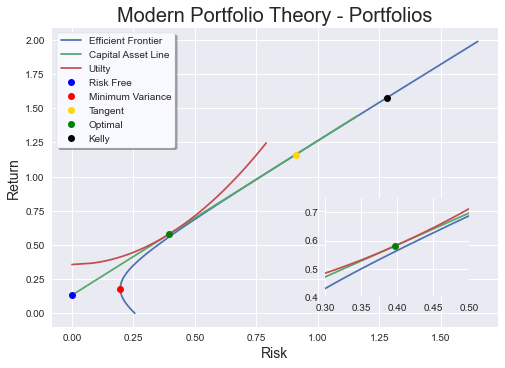

In [778]:
fig, ax = plt.subplots()

ax.plot(a2[0],a2[1], label="Efficient Frontier")
ax.plot(cal2[0],cal2[1], label="Capital Asset Line") # CAL
ax.plot(u[0],u[1], label="Utilty") # Util
ax.plot(0,r2, 'o', color='b', label="Risk Free") # rf
ax.plot(b2[0],b2[1], 'o', color='r', label="Minimum Variance") # minVar
ax.plot(c2[0],c2[1], 'o', color='gold', label="Tangent") # tangent
ax.plot(d2[0],d2[1], 'o', color='g', label="Optimal") # optimal
ax.plot(k2[0],k2[1], 'o', color='black', label="Kelly") # optimal


# location for the zoomed portion 
sub_axes = plt.axes([.6, .2, .25, .25]) 

# plot the zoomed portion
sub_axes.plot(a2[0],a2[1], label="Efficient Frontier")
sub_axes.plot(cal2[0],cal2[1], label="Capital Allocation Line") # CAL
sub_axes.plot(u[0],u[1], label="Utilty") # Util
sub_axes.plot(0,r2, 'o', color='b', label="Risk Free") # rf
sub_axes.plot(b2[0],b2[1], 'o', color='r', label="Minimum Variance") # minVar
sub_axes.plot(c2[0],c2[1], 'o', color='gold', label="Tangent") # tangent
sub_axes.plot(d2[0],d2[1], 'o', color='g', label="Optimal") # optimal
sub_axes.set_xlim(0.3,0.5)
sub_axes.set_ylim(0.4,0.75)

ax.legend(frameon=True, shadow=True, facecolor="ghostwhite")
ax.set_title("Modern Portfolio Theory - Portfolios", size=20)
ax.set_xlabel("Risk", size=14)
ax.set_ylabel("Return", size=14)
leg = ax.get_legend_handles_labels()


plt.show()
fig.savefig('MPT2.png')

In [779]:
table = pd.DataFrame([b2[2],c2[2],d2[2],k2[2]], index=leg[-1][4:],
            columns=P2.assetNames).T\
                .fillna(0)

print(table.to_latex(longtable=False, float_format="{:0.2%}".format))

\begin{tabular}{lrrrr}
\toprule
{} &  Minimum Variance &  Tangent &  Optimal &    Kelly \\
\midrule
ITUB4     &            14.77\% &   14.77\% &    6.44\% & -238.16\% \\
PETR4     &            -5.31\% &   -5.31\% &   -2.31\% &   18.31\% \\
B3SA3     &            -4.67\% &   -4.67\% &   -2.03\% & -144.77\% \\
RENT3     &            -3.59\% &   -3.59\% &   -1.56\% &   51.26\% \\
WEGE3     &            10.76\% &   10.76\% &    4.69\% &  134.31\% \\
TAEE11    &            60.05\% &   60.05\% &   26.17\% &    0.36\% \\
VALE3     &            13.44\% &   13.44\% &    5.86\% &  104.39\% \\
BPAC11    &            -4.37\% &   -4.37\% &   -1.91\% &  221.41\% \\
LCAM3     &            -1.02\% &   -1.02\% &   -0.45\% &   20.55\% \\
EQTL3     &            19.93\% &   19.93\% &    8.69\% &  -26.97\% \\
Risk Free &             0.00\% &    0.00\% &   56.41\% &  -40.68\% \\
\bottomrule
\end{tabular}



In [759]:
risk2 = RiskMetrics(d2[1],d2[0], notional = 100000)
var2 = risk2.valueAtRisk(0.05,1)
cvar2 = risk2.cValueAtRisk(0.05,1)
print('VaR: $ {:,.2f}'.format(var2))
print('CVaR: $ {:,.2f}'.format(cvar2))

VaR: $ -6,294.65
CVaR: $ -7,952.29


In [760]:
mktRiskAv = 2.5
shrink = 0.025
mktViews = [[0,0,0,0,0,0,0,0,0,1], [0,-1,0,0,0,0,1,0,0,0], [-1,0,0,0,0,0,0,1,0,0]]
retViews = [0.2,0.05, 0.08]
errorViews = [[0.002,0,0],[0,0.004,0],[0,0,0.00225]]
bl = BlackLitterman(riskAv=mktRiskAv, covMatrix = M1.mCov, mktCap= M1.mktCap, riskFree = r2, shrink = shrink,\
     mktViews = mktViews, retViews = retViews, errorViews = errorViews)

In [761]:
xx1 = pd.DataFrame(mktViews)

print(xx1.to_latex(longtable=False))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0 &  1 &  2 &  3 &  4 &  5 &  6 &  7 &  8 &  9 \\
\midrule
0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  1 \\
1 &  0 & -1 &  0 &  0 &  0 &  0 &  1 &  0 &  0 &  0 \\
2 & -1 &  0 &  0 &  0 &  0 &  0 &  0 &  1 &  0 &  0 \\
\bottomrule
\end{tabular}



In [762]:
bl.getReturns()

In [763]:
priret = pd.DataFrame(bl.returns, index=assets)

print(priret.to_latex(longtable=False, float_format="{:0.2%}".format))

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
ITUB4  & 32.17\% \\
PETR4  & 47.43\% \\
B3SA3  & 34.29\% \\
RENT3  & 36.18\% \\
WEGE3  & 29.13\% \\
TAEE11 & 20.98\% \\
VALE3  & 35.34\% \\
BPAC11 & 39.54\% \\
LCAM3  & 35.63\% \\
EQTL3  & 25.96\% \\
\bottomrule
\end{tabular}



In [764]:
bl.posterior()
bl.postReturn

[0.2881527063704111,
 0.39549020011832264,
 0.30864835948718083,
 0.32403261664043154,
 0.26878005945632294,
 0.19438446726614061,
 0.3774508361224727,
 0.36376292843563146,
 0.32030175235637065,
 0.22408560755092893]

In [753]:
blret = pd.DataFrame(bl.postReturn, index=assets)

print(blret.to_latex(longtable=False, float_format="{:0.2%}".format))

ValueError: Shape of passed values is (100, 1), indices imply (10, 1)

In [750]:
print(pd.DataFrame(bl.postCov, index=assets, columns=assets).to_latex(longtable=False))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &     ITUB4 &     PETR4 &     B3SA3 &     RENT3 &     WEGE3 &    TAEE11 &     VALE3 &    BPAC11 &     LCAM3 &     EQTL3 \\
\midrule
ITUB4  &  0.108907 &  0.092188 &  0.074895 &  0.076790 &  0.044076 &  0.029956 &  0.048781 &  0.085578 &  0.064706 &  0.047555 \\
PETR4  &  0.092188 &  0.238603 &  0.095399 &  0.105208 &  0.066516 &  0.036423 &  0.089920 &  0.114485 &  0.104231 &  0.057870 \\
B3SA3  &  0.074895 &  0.095399 &  0.162043 &  0.105856 &  0.073663 &  0.038233 &  0.053952 &  0.121251 &  0.093114 &  0.063796 \\
RENT3  &  0.076790 &  0.105208 &  0.105856 &  0.221310 &  0.076603 &  0.040169 &  0.057708 &  0.125874 &  0.171009 &  0.067594 \\
WEGE3  &  0.044076 &  0.066516 &  0.073663 &  0.076603 &  0.148563 &  0.026971 &  0.041025 &  0.072621 &  0.076699 &  0.044206 \\
TAEE11 &  0.029956 &  0.036423 &  0.038233 &  0.040169 &  0.026971 &  0.051548 &  0.019407 &  0.040574 &  0.040735 &  0.029484 \\
VALE3  &  0.048781 &  0.089920 &  0.053952 &  0

In [678]:
pd.DataFrame(bl.postCov)

,0,1,2,3,4,5,6,7,8,9
0,0.108907,0.092188,0.074895,0.076790,0.044076,0.029956,0.048781,0.085578,0.064706,0.047555
1,0.092188,0.238603,0.095399,0.105208,0.066516,0.036423,0.089920,0.114485,0.104231,0.057870
2,0.074895,0.095399,0.162043,0.105856,0.073663,0.038233,0.053952,0.121251,0.093114,0.063796
3,0.076790,0.105208,0.105856,0.221310,0.076603,0.040169,0.057708,0.125874,0.171009,0.067594
4,0.044076,0.066516,0.073663,0.076603,0.148563,0.026971,0.041025,0.072621,0.076699,0.044206
5,0.029956,0.036423,0.038233,0.040169,0.026971,0.051548,0.019407,0.040574,0.040735,0.029484
6,0.048781,0.089920,0.053952,0.057708,0.041025,0.019407,0.167922,0.068981,0.061049,0.032764
7,0.085578,0.114485,0.121251,0.125874,0.072621,0.040574,0.068981,0.249655,0.126644,0.068399
8,0.064706,0.104231,0.093114,0.171009,0.076699,0.040735,0.061049,0.126644,0.353096,0.069698
9,0.047555,0.057870,0.063796,0.067594,0.044206,0.029484,0.032764,0.068399,0.069698,0.087165


In [767]:
r2 = 0.1325
riskAv = 2.85
names = np.append(M1.returns.columns.values, 'Risk Free')
P3 = Portfolio(r2, bl.postReturn, bl.postCov, VarStdConv = False, names=names)

In [768]:
a3 = P3.efficientFrontier(vMu = np.arange(0,0.3,0.01), variance=False)
b3 = P3.minVar()
c3 = P3.tangent()
d3 = P3.optimal(riskAv)
cal3 = P3.CAL(mult = 3)
u3 = P3.util(riskAv, mult=5)
k3 = P3.kelly()

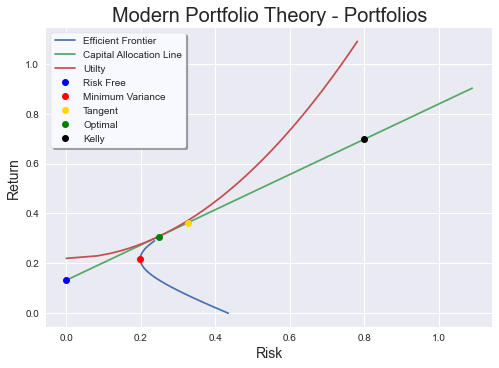

In [769]:
fig, ax = plt.subplots()

ax.plot(a3[0],a3[1], label="Efficient Frontier")
ax.plot(cal3[0],cal3[1], label="Capital Allocation Line") # CAL
ax.plot(u3[0],u3[1], label="Utilty") # Util
ax.plot(0,r2, 'o', color='b', label="Risk Free") # rf
ax.plot(b3[0],b3[1], 'o', color='r', label="Minimum Variance") # minVar
ax.plot(c3[0],c3[1], 'o', color='gold', label="Tangent") # tangent
ax.plot(d3[0],d3[1], 'o', color='g', label="Optimal") # optimal
ax.plot(k3[0],k3[1], 'o', color='black', label="Kelly") # Kelly


ax.legend(frameon=True, shadow=True, facecolor="ghostwhite")
ax.set_title("Modern Portfolio Theory - Portfolios", size=20)
ax.set_xlabel("Risk", size=14)
ax.set_ylabel("Return", size=14)
leg = ax.get_legend_handles_labels()


plt.show()

fig.savefig('MPT3.png')

In [770]:
risk3 = RiskMetrics(d3[1],d3[0], notional = 100000)
var3 = risk3.valueAtRisk(0.05,1)
cvar3 = risk3.cValueAtRisk(0.05,1)
print('VaR: $ {:,.2f}'.format(var3))
print('CVaR: $ {:,.2f}'.format(cvar3))

VaR: $ -5,036.32
CVaR: $ -6,346.75


In [771]:
table3 = pd.DataFrame([b3[2],c3[2],d3[2],k3[2]], index=leg[-1][4:],
            columns=P2.assetNames).T\
                .fillna(0)

print(table3.to_latex(longtable=False, float_format="{:0.2%}".format))

\begin{tabular}{lrrrr}
\toprule
{} &  Minimum Variance &  Tangent &  Optimal &    Kelly \\
\midrule
ITUB4     &            14.73\% &   14.73\% &   11.15\% &   35.88\% \\
PETR4     &            -5.31\% &   -5.31\% &   -4.02\% &   44.21\% \\
B3SA3     &            -4.64\% &   -4.64\% &   -3.51\% &   13.02\% \\
RENT3     &            -3.57\% &   -3.57\% &   -2.70\% &   10.98\% \\
WEGE3     &            10.70\% &   10.70\% &    8.10\% &   23.00\% \\
TAEE11    &            59.70\% &   59.70\% &   45.20\% &    2.72\% \\
VALE3     &            13.39\% &   13.39\% &   10.14\% &  109.55\% \\
BPAC11    &            -4.39\% &   -4.39\% &   -3.32\% &   29.12\% \\
LCAM3     &            -1.02\% &   -1.02\% &   -0.77\% &    2.39\% \\
EQTL3     &            20.40\% &   20.40\% &   15.44\% &  -26.51\% \\
Risk Free &             0.00\% &    0.00\% &   24.29\% & -144.37\% \\
\bottomrule
\end{tabular}

